---
# COSC2753 | Machine Learning

## Task 3: Predict the age of the paddy plant (in days) using the visual features of the paddy image.
---


# 1. Introduction

This notebook addresses Task 3 of the Assignment 2: Predict the age of the paddy plant (in days) using the visual features of the paddy image. The task is framed as a supervised regression problem, where the model estimates a continuous target variable from visual features.

Three deep learning models are developed and compared, each trained from scratch:

- **Artificial Neural Network (ANN)**: baseline model using flattened image input
- **Convolutional Neural Network (CNN)**: convolutional layers extract hierarchical spatial features
- **Deep Neural Network (DNN)**: deeper multilayer perceptron with regularization

Model performance is primarily evaluated using Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE). R² (coefficient of determination) is included as a supporting metric to assess explained variance.

The notebook presents the full machine learning pipeline, including data exploration, preprocessing, model development, evaluation, and final prediction generation.


# 2. Library Imports & Setup

This section imports essential libraries and configures global parameters for model development and training.


In [67]:
# Core Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Flatten,
    Conv2D,
    MaxPooling2D,
    BatchNormalization,
    GlobalAveragePooling2D,
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from PIL import Image

# Settings
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
SEED = 42

# Reproducibility
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 3. Load Metadata

The metadata file `meta_train.csv` contains image identifiers and their corresponding paddy plant age labels. Each image is stored in a subdirectory corresponding to its disease class.


In [68]:
# Load the CSV file
df = pd.read_csv("../data/meta_train.csv")

# Construct full image paths
df["image_path"] = df.apply(
    lambda row: os.path.join("../data/train_images", row["label"], row["image_id"]),
    axis=1,
)

# Keep only relevant columns for Task 3
df = df[["image_path", "age"]]

# Basic info
print("Total records:", len(df))
df.head()

Total records: 10407


,image_path,age
0,../data/train_images\bacterial_leaf_blight\100...,45
1,../data/train_images\bacterial_leaf_blight\100...,45
2,../data/train_images\bacterial_leaf_blight\100...,45
3,../data/train_images\bacterial_leaf_blight\100...,45
4,../data/train_images\bacterial_leaf_blight\101...,45


# 4. Exploratory Data Analysis (EDA)

This section investigates the distribution of paddy plant age labels and provides visual samples to support preprocessing and model design decisions.


### 4.1 Age Distribution

A histogram is plotted to examine the overall distribution of plant ages. This aids in understanding data balance and identifying skewness toward particular age ranges.


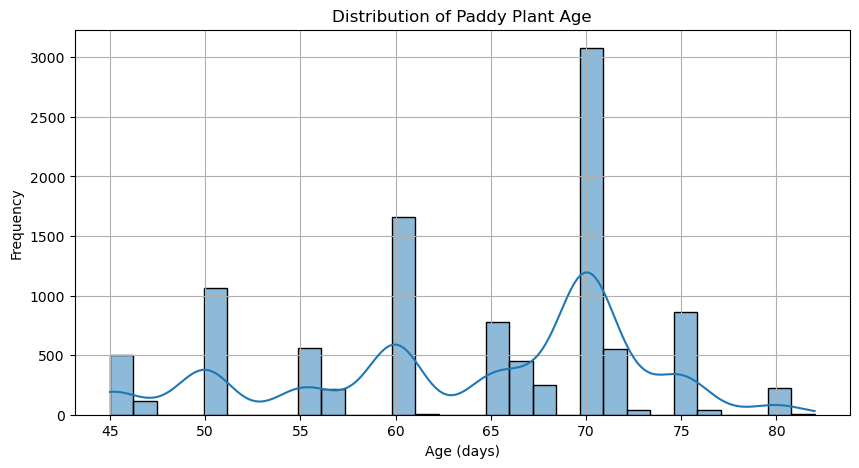

In [69]:
plt.figure(figsize=(10, 5))
sns.histplot(df["age"], bins=30, kde=True)
plt.title("Distribution of Paddy Plant Age")
plt.xlabel("Age (days)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

### 4.2 Outlier Detection

A boxplot is used to detect extreme values in the age variable. This visualization supports decisions regarding potential outlier removal or retention.


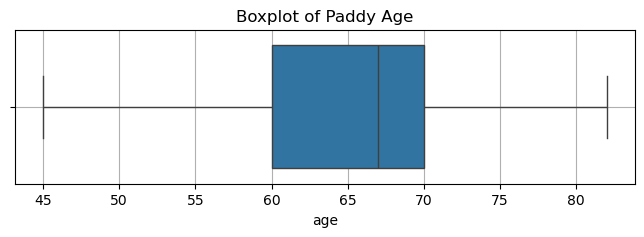

In [70]:
plt.figure(figsize=(8, 2))
sns.boxplot(x=df["age"])
plt.title("Boxplot of Paddy Age")
plt.grid(True)
plt.show()

### 4.3 Visual Inspection of Samples

Sample images from a range of ages are displayed to observe how plant appearance changes with age. Visual cues may later inform convolutional pattern recognition during training.


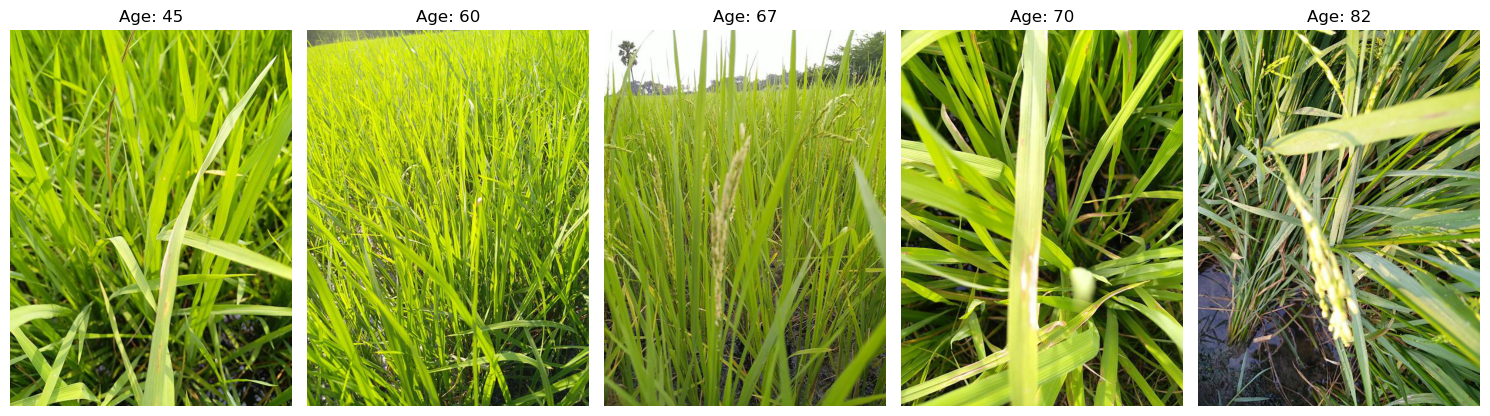

In [71]:
# Select 5 samples across the age spectrum
sample_df = df.sort_values("age").iloc[np.linspace(0, len(df) - 1, 5, dtype=int)]

plt.figure(figsize=(15, 5))
for i, row in enumerate(sample_df.itertuples()):
    plt.subplot(1, 5, i + 1)
    img = Image.open(row.image_path)
    plt.imshow(img)
    plt.title(f"Age: {row.age:.0f}")
    plt.axis("off")
plt.tight_layout()
plt.show()

# 5. Data Preprocessing

This section prepares the dataset for model training by applying consistent image transformations and organizing the data into training and validation sets.

All images are resized to 128×128 pixels and normalized to the range [0, 1]. Labels are retained as continuous values for supervised regression. Augmentation is applied only to training images during model training to enhance generalization. Preprocessed images are loaded fully into memory to support non-generator-based models such as ANN and DNN.


### 5.1 Train-Validation Split

The dataset is split into 80% training and 20% validation using a fixed random seed. Stratification is not applied, as the target variable is continuous.


In [72]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=SEED)

print("Training samples:", len(train_df))
print("Validation samples:", len(val_df))

Training samples: 8325
Validation samples: 2082


### 5.2 Image Resizing and Normalization

Each image is resized to 128×128 and scaled to the range [0, 1]. The image loading function converts all images to RGB format to ensure consistency. This step transforms raw image files into arrays suitable for model input.


In [73]:
def load_and_resize_image(path):
    img = Image.open(path).convert("RGB")
    img = img.resize(IMG_SIZE)
    return np.array(img) / 255.0  # normalize to [0, 1]

### 5.3 Load Image Arrays

All images are loaded into memory for direct use in training. This approach is compatible with custom models that do not rely on `ImageDataGenerator`.


In [74]:
X_train = np.array([load_and_resize_image(p) for p in train_df["image_path"]])
y_train = train_df["age"].values

X_val = np.array([load_and_resize_image(p) for p in val_df["image_path"]])
y_val = val_df["age"].values

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)

X_train shape: (8325, 128, 128, 3)
X_val shape: (2082, 128, 128, 3)


# 6. Model Development & Evaluation

This section presents the design, training, and evaluation of three deep learning models developed from scratch to predict the age of paddy plants from RGB images. Each model uses a different architectural approach and is evaluated using consistent metrics for comparison.

### Models Included

- **6.1 Artificial Neural Network (ANN)**: A fully connected model using flattened image inputs as features
- **6.2 Convolutional Neural Network (CNN)**: A spatially aware model that captures local and global image patterns
- **6.3 Deep Neural Network (DNN)**: A deeper fully connected model with enhanced regularization

Each model is trained using the same training and validation sets, and evaluated based on:

- **Mean Absolute Error (MAE)** – the average absolute difference between predicted and actual ages
- **Root Mean Squared Error (RMSE)** – penalizes larger errors more heavily
- **R² Score (Coefficient of Determination)** – indicates how much variance in the data is explained by the model

Performance is visualized using scatter plots of predicted vs actual values for interpretability.


## 6.1 Artificial Neural Network (ANN)

The Artificial Neural Network (ANN) serves as a baseline model by applying fully connected layers to flattened image input. This architecture does not utilize spatial relationships within the image, making it less effective for complex visual tasks but suitable for establishing a lower-bound benchmark.

### Architecture Overview

- **Input**: Flattened 128×128×3 image (49,152 features)
- **Hidden Layers**:
  - Dense(512) → ReLU → Dropout(0.3)
  - Dense(256) → ReLU → Dropout(0.2)
  - Dense(64) → ReLU
- **Output Layer**: Dense(1), linear activation

The model is compiled with the Adam optimizer and Mean Squared Error (MSE) loss. Mean Absolute Error (MAE) is used as the primary evaluation metric.


In [75]:
ann_model = Sequential(
    [
        Flatten(input_shape=(128, 128, 3)),
        Dense(512, activation="relu"),
        Dropout(0.3),
        Dense(256, activation="relu"),
        Dropout(0.2),
        Dense(64, activation="relu"),
        Dense(1),
    ]
)

ann_model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

ann_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 49152)             0         
                                                                 
 dense_9 (Dense)             (None, 512)               25166336  
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 64)                16448     
                                                                 
 dense_12 (Dense)            (None, 1)                

### Training Configuration

The model is trained for up to 50 epochs with early stopping, using a batch size of 32. Validation loss is monitored to prevent overfitting.


In [76]:
early_stop_ann = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

history_ann = ann_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop_ann],
    verbose=1,
)

Epoch 1/50
261/261 [==============================] - 10s 36ms/step - loss: 317.6097 - mae: 13.0419 - val_loss: 190.6229 - val_mae: 11.5377
Epoch 2/50
261/261 [==============================] - 9s 34ms/step - loss: 180.5976 - mae: 10.8136 - val_loss: 387.9885 - val_mae: 17.3531
Epoch 3/50
261/261 [==============================] - 9s 34ms/step - loss: 167.6344 - mae: 10.4234 - val_loss: 456.7282 - val_mae: 19.1568
Epoch 4/50
261/261 [==============================] - 9s 34ms/step - loss: 153.3296 - mae: 9.9296 - val_loss: 460.9518 - val_mae: 19.3714
Epoch 5/50
261/261 [==============================] - 9s 35ms/step - loss: 148.6592 - mae: 9.7482 - val_loss: 313.3428 - val_mae: 15.5612
Epoch 6/50
261/261 [==============================] - 9s 35ms/step - loss: 137.9893 - mae: 9.3872 - val_loss: 393.2566 - val_mae: 17.7407


### Evaluation and Performance Metrics

The model is evaluated using MAE, RMSE, and R². A scatter plot visualizes predicted versus actual age values.


In [77]:
y_pred_ann = ann_model.predict(X_val).flatten()

mae_ann = mean_absolute_error(y_val, y_pred_ann)
rmse_ann = np.sqrt(mean_squared_error(y_val, y_pred_ann))
r2_ann = r2_score(y_val, y_pred_ann)

print(f"ANN MAE: {mae_ann:.2f}")
print(f"ANN RMSE: {rmse_ann:.2f}")
print(f"ANN R²: {r2_ann:.4f}")

66/66 [==============================] - 1s 10ms/step
ANN MAE: 11.54
ANN RMSE: 13.81
ANN R²: -1.3524


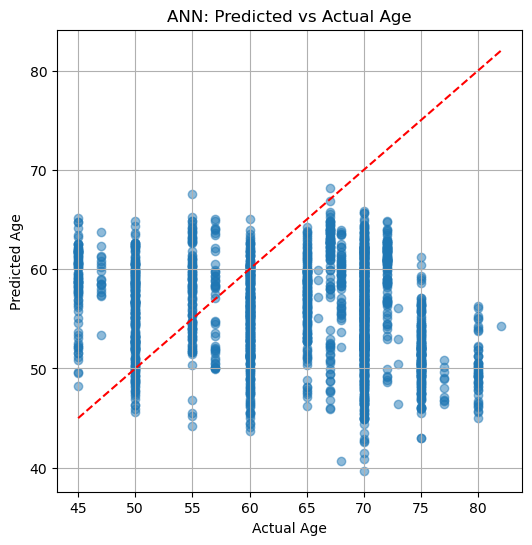

In [78]:
plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_pred_ann, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], "r--")
plt.xlabel("Actual Age")
plt.ylabel("Predicted Age")
plt.title("ANN: Predicted vs Actual Age")
plt.grid(True)
plt.show()

## 6.2 Convolutional Neural Network (CNN)

This section presents a custom Convolutional Neural Network (CNN) designed to extract spatial features from RGB images for age prediction. Unlike fully connected architectures, CNNs preserve spatial hierarchies using convolutional filters and pooling operations, making them well-suited for visual regression tasks.

### Architecture Overview

The model consists of sequential convolution and pooling layers, followed by dense layers for regression:

- **Input**: 128×128×3 image
- **Convolution Blocks**:
  - Conv2D(32) → ReLU → MaxPooling2D
  - Conv2D(64) → ReLU → MaxPooling2D
  - Conv2D(128) → ReLU → MaxPooling2D
- **Fully Connected Head**:
  - Flatten → Dense(128) → Dropout(0.3)
  - Dense(64) → Dropout(0.2)
  - Dense(1) – linear output for regression

The model is compiled with Mean Squared Error loss and optimized using the Adam optimizer. MAE, RMSE, and R² are used for evaluation.


In [79]:
cnn_model = Sequential(
    [
        Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.3),
        Dense(64, activation="relu"),
        Dropout(0.2),
        Dense(1),
    ]
)

cnn_model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)     

### Training Configuration

Training is performed for up to 50 epochs with early stopping based on validation loss. A batch size of 32 is used to maintain balance between speed and stability.


In [80]:
early_stop_cnn = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

history_cnn = cnn_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop_cnn],
    verbose=1,
)

Epoch 1/50
261/261 [==============================] - 29s 110ms/step - loss: 267.7168 - mae: 12.5682 - val_loss: 132.8482 - val_mae: 10.2099
Epoch 2/50
261/261 [==============================] - 32s 122ms/step - loss: 164.1878 - mae: 10.3653 - val_loss: 186.4498 - val_mae: 12.0743
Epoch 3/50
261/261 [==============================] - 43s 163ms/step - loss: 156.8001 - mae: 10.1112 - val_loss: 175.1608 - val_mae: 11.6797
Epoch 4/50
261/261 [==============================] - 29s 112ms/step - loss: 140.1304 - mae: 9.5473 - val_loss: 128.1189 - val_mae: 10.0568
Epoch 5/50
261/261 [==============================] - 30s 114ms/step - loss: 143.3411 - mae: 9.7127 - val_loss: 172.2133 - val_mae: 11.4980
Epoch 6/50
261/261 [==============================] - 30s 115ms/step - loss: 129.9935 - mae: 9.1785 - val_loss: 176.8529 - val_mae: 11.7807
Epoch 7/50
261/261 [==============================] - 31s 117ms/step - loss: 129.8095 - mae: 9.1924 - val_loss: 179.2650 - val_mae: 11.8854
Epoch 8/50
261/26

### Evaluation and Performance Metrics

The model is evaluated on the validation set using three standard metrics. A scatter plot visualizes the alignment between predicted and actual values.


In [81]:
y_pred_cnn = cnn_model.predict(X_val).flatten()

mae_cnn = mean_absolute_error(y_val, y_pred_cnn)
rmse_cnn = np.sqrt(mean_squared_error(y_val, y_pred_cnn))
r2_cnn = r2_score(y_val, y_pred_cnn)

print(f"CNN MAE: {mae_cnn:.2f}")
print(f"CNN RMSE: {rmse_cnn:.2f}")
print(f"CNN R²: {r2_cnn:.4f}")

66/66 [==============================] - 2s 36ms/step
CNN MAE: 6.82
CNN RMSE: 8.09
CNN R²: 0.1921


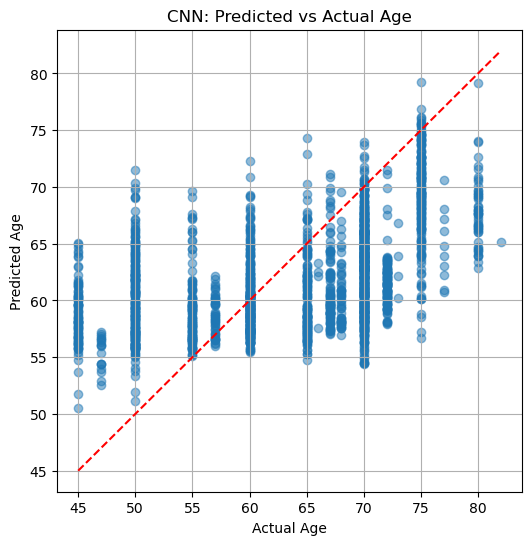

In [82]:
plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_pred_cnn, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], "r--")
plt.xlabel("Actual Age")
plt.ylabel("Predicted Age")
plt.title("CNN: Predicted vs Actual Age")
plt.grid(True)
plt.show()

## 6.3 Deep Neural Network (DNN)

This section presents a Deep Neural Network (DNN) model for predicting paddy plant age using flattened image input. Unlike the ANN baseline, the DNN contains additional hidden layers and regularization mechanisms to increase its representation capacity and reduce overfitting.

This model helps evaluate whether deeper fully connected networks, without spatial filters, can perform competitively with convolutional architectures.

### Architecture Overview

- **Input**: Flattened 128×128×3 image (49,152 features)
- **Hidden Layers**:
  - Dense(1024) → ReLU → Dropout(0.3)
  - Dense(512) → ReLU → Dropout(0.2)
  - Dense(256) → ReLU
  - Dense(64) → ReLU
- **Output Layer**: Dense(1), linear activation

The model is compiled with the Adam optimizer and Mean Squared Error loss. Evaluation is performed using MAE, RMSE, and R².


In [83]:
dnn_model = Sequential(
    [
        Flatten(input_shape=(128, 128, 3)),
        Dense(1024, activation="relu"),
        Dropout(0.3),
        Dense(512, activation="relu"),
        Dropout(0.2),
        Dense(256, activation="relu"),
        Dense(64, activation="relu"),
        Dense(1),
    ]
)

dnn_model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

dnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 49152)             0         
                                                                 
 dense_16 (Dense)            (None, 1024)              50332672  
                                                                 
 dropout_9 (Dropout)         (None, 1024)              0         
                                                                 
 dense_17 (Dense)            (None, 512)               524800    
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 256)               131328    
                                                                 
 dense_19 (Dense)            (None, 64)               

### Training Configuration

The model is trained using early stopping based on validation loss, with a maximum of 50 epochs and a batch size of 32.


In [84]:
early_stop_dnn = EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)

history_dnn = dnn_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop_dnn],
    verbose=1,
)

Epoch 1/50
261/261 [==============================] - 18s 66ms/step - loss: 249.0790 - mae: 11.9160 - val_loss: 133.5441 - val_mae: 9.2934
Epoch 2/50
261/261 [==============================] - 17s 63ms/step - loss: 166.4452 - mae: 10.3842 - val_loss: 235.9199 - val_mae: 13.1593
Epoch 3/50
261/261 [==============================] - 17s 64ms/step - loss: 160.3996 - mae: 10.1511 - val_loss: 286.7113 - val_mae: 14.7552
Epoch 4/50
261/261 [==============================] - 17s 64ms/step - loss: 158.8458 - mae: 10.0870 - val_loss: 152.7704 - val_mae: 10.4210


### Evaluation and Performance Metrics

Evaluation is performed on the validation set using standard regression metrics. A scatter plot visualizes the predictions in comparison to ground truth values.


In [87]:
y_pred_dnn = dnn_model.predict(X_val).flatten()

mae_dnn = mean_absolute_error(y_val, y_pred_dnn)
rmse_dnn = np.sqrt(mean_squared_error(y_val, y_pred_dnn))
r2_dnn = r2_score(y_val, y_pred_dnn)

print(f"DNN MAE: {mae_dnn:.2f}")
print(f"DNN RMSE: {rmse_dnn:.2f}")
print(f"DNN R²: {r2_dnn:.4f}")

66/66 [==============================] - 1s 12ms/step
DNN MAE: 9.29
DNN RMSE: 11.56
DNN R²: -0.6480


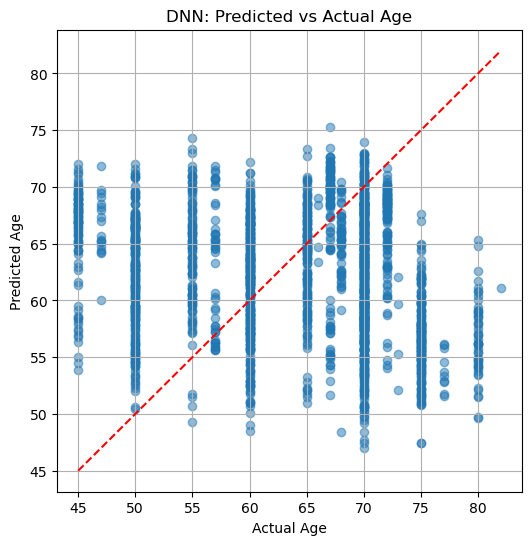

In [88]:
plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_pred_dnn, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], "r--")
plt.xlabel("Actual Age")
plt.ylabel("Predicted Age")
plt.title("DNN: Predicted vs Actual Age")
plt.grid(True)
plt.show()

## 6.4 Transfer Learning – EfficientNetB0

This section applies a pretrained EfficientNetB0 model as a feature extractor for predicting paddy plant age. Transfer learning leverages convolutional features learned from large-scale image datasets (e.g., ImageNet), allowing models to generalize better on smaller or domain-specific datasets.

EfficientNetB0 is selected due to its optimal trade-off between accuracy and computational efficiency. The base model is frozen to retain pretrained weights, and only a custom regression head is trained.

### Architecture Overview

- **Base Model**: EfficientNetB0 pretrained on ImageNet (excluding top classification layer)
- **Custom Head**:
  - GlobalAveragePooling2D
  - Dense(128) → ReLU → Dropout(0.3)
  - Dense(1) – linear output for regression

The model uses MSE loss and is optimized with Adam. This configuration allows fine-tuning of the regression head while preserving pretrained spatial features.


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input

# Define base model
base_model = EfficientNetB0(
    input_shape=(128, 128, 3), include_top=False, weights="imagenet"
)
base_model.trainable = False  # Freeze pretrained layers

# Add custom regression head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(1)(x)

effnet_model = Model(inputs=base_model.input, outputs=output)

effnet_model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

effnet_model.summary()

16705208/16705208 [==============================] - 2s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 128, 128, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 128, 128, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)   

### Training Configuration

The model is trained with early stopping on validation loss. Only the custom top layers are updated during training.


In [90]:
early_stop_effnet = EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)

history_effnet = effnet_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop_effnet],
    verbose=1,
)

Epoch 1/30
261/261 [==============================] - 38s 124ms/step - loss: 485.8710 - mae: 15.5619 - val_loss: 81.2916 - val_mae: 7.7479
Epoch 2/30
261/261 [==============================] - 32s 123ms/step - loss: 130.4920 - mae: 9.2518 - val_loss: 81.0560 - val_mae: 7.7218
Epoch 3/30
261/261 [==============================] - 33s 125ms/step - loss: 127.7756 - mae: 9.2020 - val_loss: 80.9531 - val_mae: 7.7213
Epoch 4/30
261/261 [==============================] - 33s 125ms/step - loss: 129.6632 - mae: 9.2209 - val_loss: 82.3770 - val_mae: 7.9604
Epoch 5/30
261/261 [==============================] - 34s 129ms/step - loss: 127.9758 - mae: 9.1801 - val_loss: 81.8434 - val_mae: 7.9148
Epoch 6/30
261/261 [==============================] - 34s 129ms/step - loss: 128.9760 - mae: 9.1925 - val_loss: 81.0003 - val_mae: 7.8219


### Evaluation and Performance Metrics

The model is evaluated using MAE, RMSE, and R² on the validation set. A scatter plot is used to visualize prediction accuracy.


In [91]:
y_pred_effnet = effnet_model.predict(X_val).flatten()

mae_effnet = mean_absolute_error(y_val, y_pred_effnet)
rmse_effnet = np.sqrt(mean_squared_error(y_val, y_pred_effnet))
r2_effnet = r2_score(y_val, y_pred_effnet)

print(f"EfficientNetB0 MAE: {mae_effnet:.2f}")
print(f"EfficientNetB0 RMSE: {rmse_effnet:.2f}")
print(f"EfficientNetB0 R²: {r2_effnet:.4f}")

66/66 [==============================] - 7s 86ms/step
EfficientNetB0 MAE: 7.72
EfficientNetB0 RMSE: 9.00
EfficientNetB0 R²: 0.0010


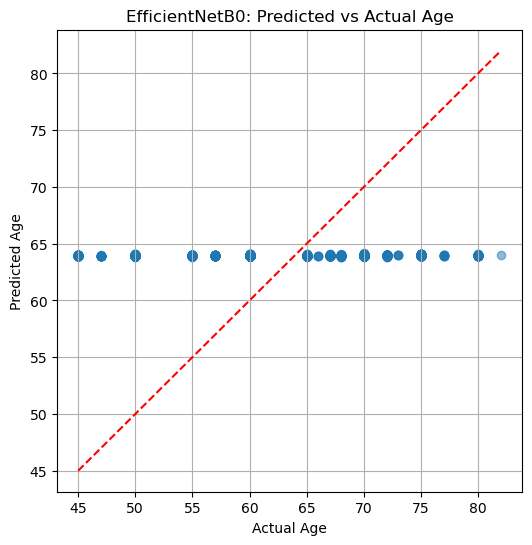

In [92]:
plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_pred_effnet, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], "r--")
plt.xlabel("Actual Age")
plt.ylabel("Predicted Age")
plt.title("EfficientNetB0: Predicted vs Actual Age")
plt.grid(True)
plt.show()

# 7. Final Prediction

This section generates age predictions on unseen test images using the best-performing model (CNN). Since no metadata file is provided, image file names are used directly to construct the submission file.


In [100]:
import glob

# Load test image paths
test_image_paths = sorted(glob.glob("../data/test_images/*.jpg"))

# Extract image IDs from file names
image_ids = [os.path.splitext(os.path.basename(path))[0] for path in test_image_paths]

# Preprocess each image
X_test = np.array([load_and_resize_image(path) for path in test_image_paths])


In [101]:
X_test.shape

(3469, 128, 128, 3)

In [102]:
# Predict ages
y_test_pred = cnn_model.predict(X_test).flatten()


109/109 [==============================] - 4s 36ms/step


In [103]:
# Build DataFrame for submission
submission_df = pd.DataFrame({
    "image_id": image_ids,
    "age": y_test_pred
})

# Save to CSV
submission_df.to_csv("../prediction/task3_submission.csv", index=False)
print("Saved: task3_submission.csv")


Saved: task3_submission.csv


In [104]:
# Save model architecture and weights
cnn_model.save("../models/cnn_age_prediction_model.keras")
print("Model saved: ../models/cnn_age_prediction_model.keras")


Model saved: ../models/cnn_age_prediction_model.keras


# 8. Conclusion

This project addressed the task of predicting paddy plant age from RGB images using deep learning techniques. A complete pipeline was implemented, covering metadata processing, image preprocessing, model training, evaluation, and final inference.

### Summary of Models

Four different models were developed and evaluated:

| Model           | MAE   | RMSE  | R²      |
|----------------|--------|--------|----------|
| ANN            | 11.54 | 13.81 | -1.3524 |
| CNN (Selected) | 6.82  | 8.09  | 0.1921  |
| DNN            | 9.29  | 11.56 | -0.6480 |
| EfficientNetB0 | 7.72  | 9.00  | 0.0010  |

The Convolutional Neural Network (CNN) demonstrated the best overall performance across all metrics and was selected for final predictions. The ANN and DNN models underperformed due to their inability to capture spatial features, while EfficientNetB0 showed potential but did not outperform the custom CNN.

### Key Insights

- Spatial feature extraction is critical for image-based regression tasks.  
- Deeper fully connected models do not necessarily improve performance without convolutional structure.  
- Transfer learning models like EfficientNetB0 can offer competitive results, but require fine-tuning for optimal performance.  
- Proper preprocessing (resizing, normalization) is essential for consistent results.

The final CNN model and prediction results have been saved and are ready for evaluation or deployment.
